In [27]:
import pandas as pd 
import re 
import string 
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk.corpus  
from nltk.text import Text 
from PIL import Image
from textblob import TextBlob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


In [28]:
# Load the tweets
Tweets = pd.read_csv("tweets_raw.csv", index_col = 0)

# Drop uneccessary 'Unnamed: 0.1 column'
Tweets.drop("Unnamed: 0.1", axis=1, inplace=True)

# Drop duplicated rows
Tweets.drop_duplicates(inplace=True)
Tweets.reset_index(drop=True, inplace=True)

# Change "Created at" to the datatype datetime
Tweets["Created at"] = pd.to_datetime(Tweets["Created at"])

# Fill in missing values for location 
Tweets["Location"].fillna("unknown", inplace=True)

Tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187052 entries, 0 to 187051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Content        187052 non-null  object        
 1   Location       187052 non-null  object        
 2   Username       187052 non-null  object        
 3   Retweet-Count  187052 non-null  int64         
 4   Favorites      187052 non-null  int64         
 5   Created at     187052 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 8.6+ MB


In [29]:
# Pre-Processing Function 
def preprocess_text(text): 
    # get lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove urls
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    # strip whitespace
    text = text.strip()
    
    # remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    words = [w for w in tokens if not w in stop_words]
    text = " ".join(w for w in words)
    
    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokens = word_tokenize(text)
    words = [w for w in tokens if w.isalpha() and len(w)>2]
    text = " ".join(w for w in words)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    words = [lemmatizer.lemmatize(w, pos = 'a') for w in tokens]
    result = " ".join(w for w in words)
    return result

In [30]:
# Process tweets
Tweets['processed_post'] = [preprocess_text(post) for post in Tweets['Content'].values]

In [31]:
def get_sentiment(post): 
    blob = TextBlob(post) 
    return blob.sentiment 

from textblob import TextBlob
# Get sentiment and append into dataframe
polarity = []
subjectivity = []
for post in Tweets['processed_post']:
    polar = get_sentiment(post).polarity
    polarity.append(polar)
    subjec = get_sentiment(post).subjectivity
    subjectivity.append(subjec)
    
Tweets['polarity'] = polarity
Tweets['subjectivity'] = subjectivity

In [32]:
# Classify tweets as positive, negative, or neutral based on polarity
polarity = [None] * len(Tweets) 

for i in range(0, len(Tweets)):
    if Tweets["polarity"][i] > 0:
        polarity[i] = "Positive"
    elif Tweets["polarity"][i] == 0:
        polarity[i] = "Neutral"
    else:
        polarity[i] = "Negative"

Tweets["Label"] = polarity

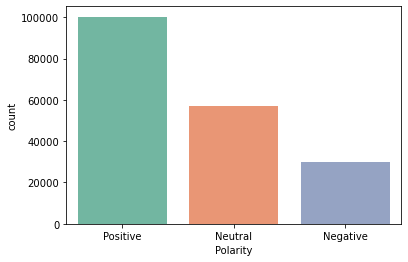

In [33]:
# Examine distribution of tweet sentiments
import seaborn as sns 
import matplotlib.pyplot as plt 

ax = sns.countplot(x ='Label', data = Tweets, palette = "Set2")
ax.set(xlabel='Polarity')
plt.show()

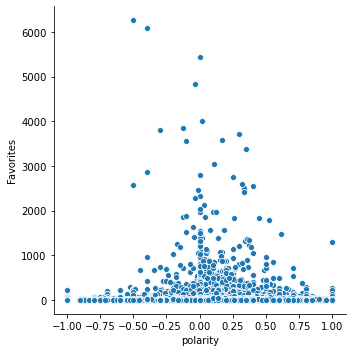

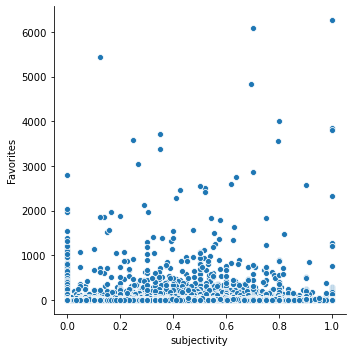

In [66]:
# Remove outliers from favorites for a better visualization
# of the relationship between favorites and polarity
favorites = Tweets[Tweets["Favorites"] < 8000]

sns.relplot(x="polarity", y="Favorites", data=favorites)
sns.relplot(x="subjectivity", y="Favorites", data=favorites)

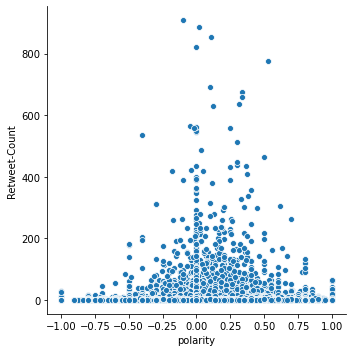

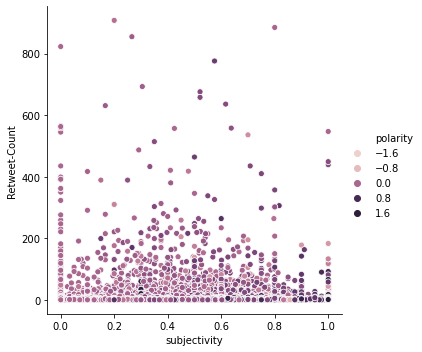

In [67]:
retweets = Tweets[Tweets["Retweet-Count"] < 1000]
sns.relplot(x="polarity", y="Retweet-Count", data=retweets)
sns.relplot(x="subjectivity", y="Retweet-Count", data=retweets)

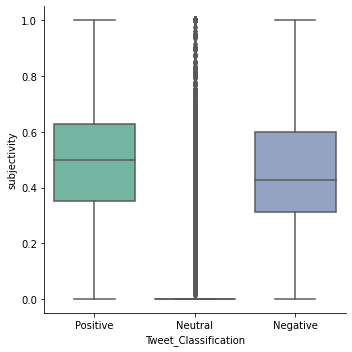

In [8]:
# Examine the relationship between subjectivity and polarity
sns.catplot(x="Tweet_Classification", y="subjectivity", kind="box", data=Tweets, palette = "Set2")

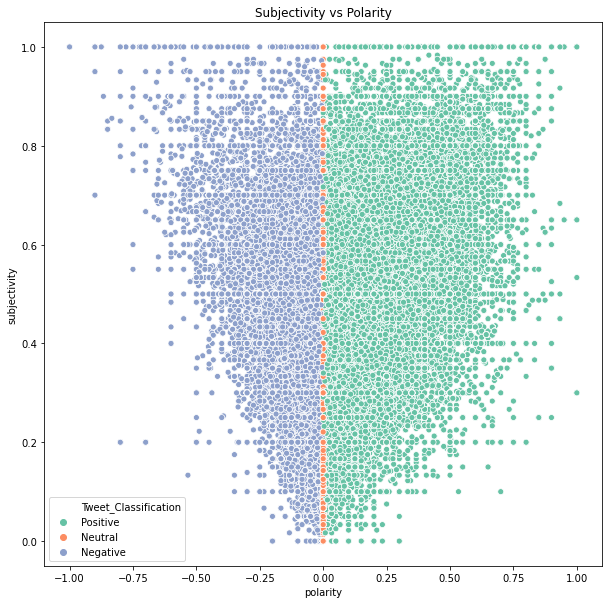

In [9]:
# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="polarity", y="subjectivity", hue="Tweet_Classification", data=Tweets, palette = "Set2")
plt.title("Subjectivity vs Polarity")
plt.show()

In [10]:
# Look at popular words for positive and negative tweets
# Create DataFrames for each label
positive_df = Tweets.sort_values(by=["polarity","Favorites","Retweet-Count", ], axis=0,
    ascending=[False, False, False])[["Content","Retweet-Count","Favorites","polarity","processed_post"]].head(50)

negative_df = Tweets.sort_values(by=["polarity", "Favorites", "Retweet-Count"], axis=0, 
    ascending=[True, False, False])[["Content","Retweet-Count","Favorites","polarity","processed_post"]].head(50)

objective_df = Tweets.sort_values(by=["subjectivity","Favorites","Retweet-Count", ], axis=0,
    ascending=[True, False, False])[["Content","Retweet-Count","Favorites","subjectivity","processed_post"]].head(30)

subjective_df = Tweets.sort_values(by=["subjectivity","Favorites","Retweet-Count", ], axis=0,
    ascending=[False, False, False])[["Content","Retweet-Count","Favorites","subjectivity","processed_post"]].head(30)

posts = positive_df.processed_post.values
positive_text = " ".join(t for t in posts)

posts = negative_df.processed_post.values
negative_text = " ".join(t for t in posts)

posts = subjective_df.processed_post.values
subjective_text = " ".join(t for t in posts)

posts = objective_df.processed_post.values
objective_text = " ".join(t for t in posts)

In [11]:
# Identify the stopwords used to gather tweets
tfidf_stops = ["online", "class", "course", "learning", "learn","teach", "teaching", "distance", \
               "distancelearning", "education", "teacher", "student", "grade", "classes", "computer", "resource", \
               "onlineeducation", "onlinelearning", "school", "students", "class", "virtual", "eschool", "thing", \
               "virtuallearning", "educated", "educates", "teaches", "studies", "study", "semester", "elearning", \
               "teachers", "lecturer", "lecture", "amp", "academic", "admission", "academician", "account", "action",\
               "add", "app", "announcement", "application", "adult", "classroom", "system", "video", "essay", "training", \
               "homework","work","assignment", "paper", "get", "math", "project", "science", "physics", "lesson", "schools", \
               "courses", "assignments", "know", "instruction","email", "discussion","home", "college", "exam", "university", \
               "use", "fall", "term", "proposal", "one", "review", "proposal", "calculus", "search", "research", "algebra", \
               "internet", "remote", "remotelearning"]


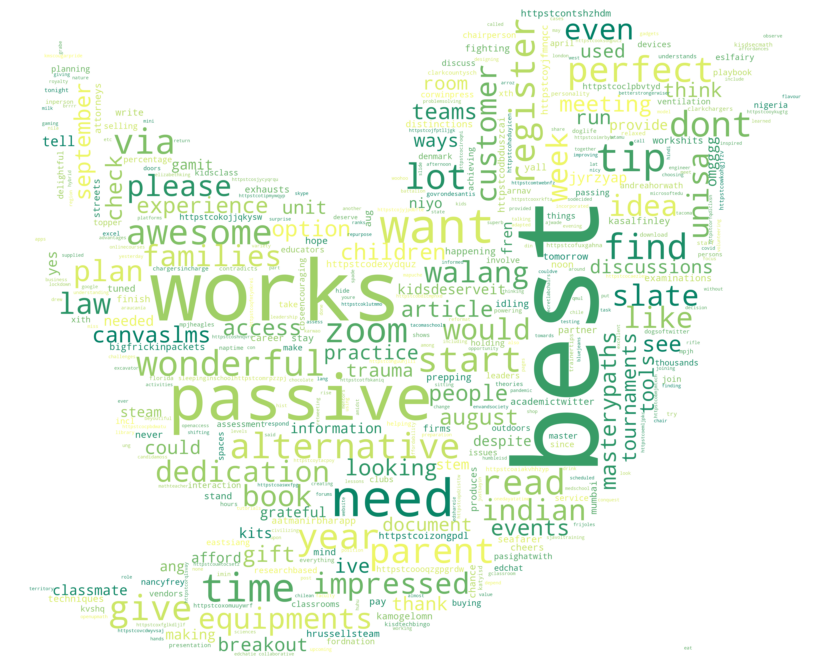

In [12]:
# Positive tweets
mask = np.array(Image.open("Unknown.png"))

wordcloud = WordCloud(mask = mask, stopwords = tfidf_stops, max_font_size=100, max_words = 500, width = 400, height = 300, background_color = 'white',
                      scale = 6, collocations=False, colormap = 'summer').generate(positive_text)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

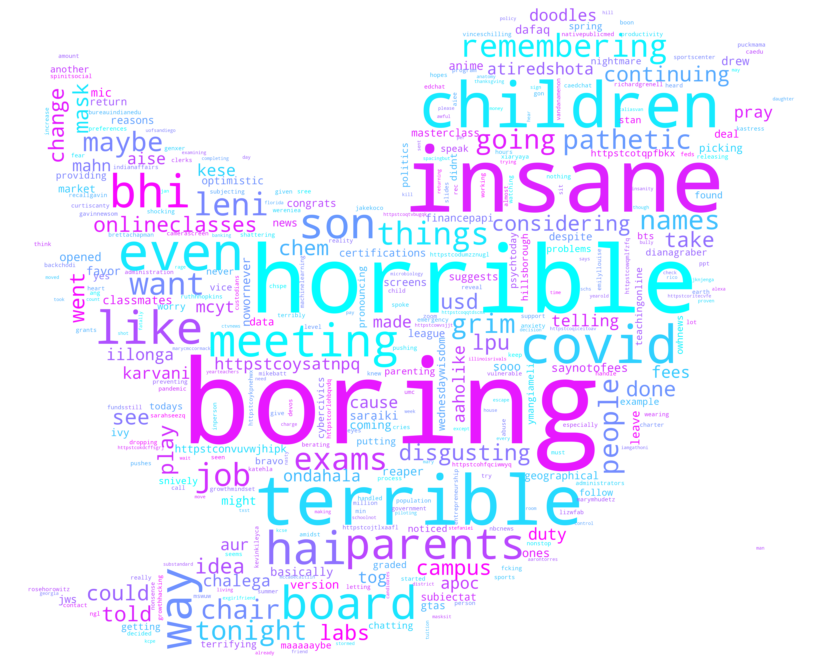

In [13]:
# Negative Tweets
mask = np.array(Image.open("Unknown.png"))

wordcloud = WordCloud(mask = mask, stopwords = tfidf_stops, max_font_size=100, max_words = 500, width = 400, height = 300, background_color = 'white',
                      scale = 6, collocations=False, colormap = 'cool').generate(negative_text)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()